In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Pet_Supplies.csv.gz to Pet_Supplies.csv.gz


Count the number of user and product Ids


In [ ]:
import pandas as pd
import gzip

file_name = "Pet_Supplies.csv.gz"  # Replace with your actual filename
df = pd.read_csv(file_name, compression='gzip')

# Display first few rows
df.head(10)


,user_id,parent_asin,rating,timestamp
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B079QFP1F5,4.0,1545114749534
1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B0BP3XMDP2,5.0,1583557116498
2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B0986BSRB1,3.0,1587853303681
3,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B0BM6V2SH8,5.0,1589933838188
4,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B0BX76YVP9,3.0,1656118516820
5,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B0BJ16KKML,1.0,1665513673369
6,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B0BHTBS5RM,4.0,1675529329744
7,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,B08D8FC4MG,5.0,1286646315000
8,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,B00BUFSX7G,5.0,1501598487861
9,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,B0BFYZY2DZ,5.0,1581948892227


In [ ]:
# Count before filtering
count_before = len(df)

# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Filter for data from the year 2020
df_filtered = df[df['timestamp'].dt.year == 2020]


# Get unique counts of users and products
num_users = df_filtered['user_id'].nunique()
num_products = df_filtered['parent_asin'].nunique()

# Print results
print(f"Total unique users after 2019: {num_users}")
print(f"Total unique products after 2019: {num_products}")

# Count after filtering
count_after = len(df_filtered)

# Print results
print(f"Number of records before filtering: {count_before}")
print(f"Number of records after filtering (2020 only): {count_after}")

Total unique users after 2019: 264184
Total unique products after 2019: 57486
Number of records before filtering: 5277315
Number of records after filtering (2020 only): 705416


In [ ]:
import requests
from bs4 import BeautifulSoup

def get_category(asin):
    url = f"https://www.amazon.com/dp/{asin}"
    headers = {"User-Agent": "Mozilla/5.0"}

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        category = soup.find("span", {"class": "nav-a-content"})  # Adjust selector based on structure
        return category.text.strip() if category else "Unknown"
    else:
        return "Not Found"

# Example usage
asin_list = ["B079QFP1F5", "B0BP3XMDP2"]
asin_to_category = {asin: get_category(asin) for asin in asin_list}
print(asin_to_category)


{'B079QFP1F5': 'Unknown', 'B0BP3XMDP2': 'Not Found'}


New user with no purchase history
Recommend the top-rated and most popular products


In [ ]:
# Aggregate rating count and average rating for each product
product_stats = df.groupby('parent_asin').agg(
    total_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

# Define a weighted score using Bayesian Average
def bayesian_avg_rating(row, m=50, C=4.0):
    """
    Bayesian Average Rating formula:
    Weighted Score = (v / (v + m)) * R + (m / (v + m)) * C
    Where:
    - R = avg rating for the product
    - v = total number of ratings for the product
    - m = minimum votes required to be considered (hyperparameter, 50 is a good default)
    - C = mean rating across all products (defaulted to 4.0)
    """
    R = row['avg_rating']
    v = row['total_ratings']
    return (v / (v + m)) * R + (m / (v + m)) * C

# Apply Bayesian Average Ranking
product_stats['bayesian_score'] = product_stats.apply(bayesian_avg_rating, axis=1)

# Sort products by Bayesian score in descending order
top_10_products = product_stats.sort_values(by='bayesian_score', ascending=False).head(10)

# Display the top 10 products
print("Top 10 Recommended Products without collaborative filtering:")
print(top_10_products)

Top 10 Recommended Products without collaborative filtering:
       parent_asin  total_ratings  avg_rating  bayesian_score
58412   B07JFN4M25            789    4.903676        4.849821
107081  B0BMK5L5XX           2679    4.828667        4.813485
48043   B075RSYCDB           1900    4.819474        4.798462
61463   B07NV4T23H            741    4.846154        4.792668
8297    B002UUV2DW           3487    4.798107        4.786825
86524   B093XSL3ZP           2396    4.801753        4.785364
11684   B004PJ55KC            998    4.817635        4.778626
58227   B07J5M32NW            578    4.842561        4.775478
90050   B09CMFPP47           1000    4.807000        4.768571
95433   B09R54RYLM           3847    4.776189        4.766230


explicit ratings --> user-based collaborative filtering

In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Limit to Top Users and Top Products to Reduce Memory Usage
top_users = df['user_id'].value_counts().head(1000).index  # Limit to 1000 top users
top_products = df['parent_asin'].value_counts().head(500).index  # Limit to 500 top products
df_filtered = df[df['user_id'].isin(top_users) & df['parent_asin'].isin(top_products)]

# Create a User-Item Ratings Matrix (Sparse Format)
user_item_matrix = df_filtered.pivot(index='user_id', columns='parent_asin', values='rating').fillna(0)
sparse_matrix = csr_matrix(user_item_matrix)

# Use Approximate Nearest Neighbors (Faster than Cosine Similarity)
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(sparse_matrix)

# Function to Recommend Products Based on Similar Users -> find 5 most similar user
def recommend_for_user(user_id, model, user_item_matrix, n_recommendations=5):
    if user_id not in user_item_matrix.index:
        return f"User {user_id} not found in dataset."

    # Get the row index of the user
    user_idx = user_item_matrix.index.get_loc(user_id)

    # Find the most similar users
    distances, indices = model.kneighbors([user_item_matrix.iloc[user_idx]], n_neighbors=6)  # 5 similar users + self

    # Aggregate ratings from similar users
    similar_users = user_item_matrix.iloc[indices[0][1:]]  # Ignore first result (self)
    recommended_products = similar_users.mean().sort_values(ascending=False).head(n_recommendations)

    return recommended_products

# Example: Recommend products for a top user
sample_user = top_users[0]
recommended_products = recommend_for_user(sample_user, model, user_item_matrix)

# Display Results
from IPython.display import display
recommended_df = recommended_products.to_frame().reset_index()
recommended_df.columns = ['Product ASIN', 'Predicted Rating']
print("The top 5 highest-rated products among those are recommended to the user(UBS w. Nearest Neighbors)")
print(f"Recommended Products for User {sample_user}:")
display(recommended_df)

The top 5 highest-rated products among those are recommended to the user(UBS w. Nearest Neighbors)
Recommended Products for User AG73BVBKUOH22USSFJA5ZWL7AKXA:


,Product ASIN,Predicted Rating
0,B099F9JBYR,3.0
1,B09D451T23,2.6
2,B0862YK5RP,2.6
3,B095MMN2F1,2.0
4,B0C6B9GR9G,2.0


Interpretation:

The predicted ratings represent how highly this user is expected to rate these products based on the preferences of similar users.
The highest-ranked product (B099F9JYBRN) has a predicted rating of 3.0, meaning similar users have given it relatively good feedback.
Lower-rated products (e.g., B095MMNMF2) still show up, likely because similar users rated them and the user has limited interactions.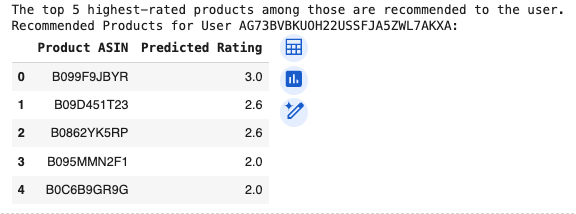

Improvements & Next Steps:

Improve Recommendation Accuracy

- Instead of averaging ratings, use weighted averages where closer users get more influence.
Implement Singular Value Decomposition (SVD) for a matrix factorization approach.

- Combine with Item-Based Filtering

Instead of recommending based on similar users, use item similarity (products frequently bought together).
This helps when a user has unique tastes that don’t match similar users.

- Add Product Names Instead of ASINs

You can map ASINs to product names for better interpretability

Compute cosine similarity between users.
Give higher weights to more similar users.
Normalize by the sum of similarity scores.

In [ ]:
# crashed using cosine similarities

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix


# Create User-Item Ratings Matrix (Sparse Format)
user_item_matrix = df.pivot(index='user_id', columns='parent_asin', values='rating').fillna(0)
sparse_matrix = csr_matrix(user_item_matrix)

# Compute Cosine Similarity Between Users
user_similarity = cosine_similarity(sparse_matrix)

# Convert to DataFrame for easier handling
user_sim_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Function to recommend products using weighted ratings
def recommend_weighted(user_id, user_sim_df, user_item_matrix, n_recommendations=5):
    if user_id not in user_sim_df.index:
        return f"User {user_id} not found in dataset."

    # Find most similar users
    similar_users = user_sim_df[user_id].sort_values(ascending=False).iloc[1:6]  # Top 5 similar users

    # Get their ratings
    similar_users_ratings = user_item_matrix.loc[similar_users.index]

    # Compute weighted ratings
    weighted_ratings = (similar_users_ratings.T * similar_users.values).T
    weighted_avg_ratings = weighted_ratings.sum(axis=0) / similar_users.values.sum()

    # Get top recommended products
    recommended_products = weighted_avg_ratings.sort_values(ascending=False).head(n_recommendations)

    return recommended_products

# Example: Recommend products for a top user
sample_user = df['user_id'].value_counts().index[0]  # Pick the most active user
recommended_products = recommend_weighted(sample_user, user_sim_df, user_item_matrix)

# Display Recommendations
from IPython.display import display
recommended_df = recommended_products.to_frame().reset_index()
recommended_df.columns = ['Product ASIN', 'Predicted Rating']
print("user-based collaborative filtering with weighted averaging and cosine similarity")
print(f"Recommended Products for User {sample_user}:")
display(recommended_df)





<ipython-input-10-9a313eee4482>:10: PerformanceWarning: The following operation may generate 15186881424 cells in the resulting pandas object.
  user_item_matrix = df.pivot(index='user_id', columns='parent_asin', values='rating').fillna(0)


Since Surprise does not work well with Colab's TensorFlow setup, a better alternative is Matrix Factorization via Alternating Least Squares (ALS) using the implicit library. This method is similar to SVD but works on sparse matrices efficiently.

In [ ]:



pip uninstall -y numpy scikit-surprise

pip install numpy==1.23.5

pip install scikit-surprise --no-cache-dir



import surprise
print(surprise.__version__)


# Install the Surprise library if not installed
!pip install scikit-surprise

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load dataset
file_name = "Pet_Supplies.csv.gz"
df = pd.read_csv(file_name, compression='gzip')

# Convert timestamp to datetime and filter 2020 data
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df[df['timestamp'].dt.year == 2020]

# Define rating scale
reader = Reader(rating_scale=(1, 5))

# Load dataset into Surprise format
data = Dataset.load_from_df(df[['user_id', 'parent_asin', 'rating']], reader)

# Split into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Define and train the SVD model
model = SVD(n_factors=50, random_state=42)  # Adjust n_factors for better performance
model.fit(trainset)

# Evaluate model on test data
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Function to recommend top products using SVD
def recommend_svd(user_id, model, df, n_recommendations=5):
    user_products = df[df['user_id'] == user_id]['parent_asin'].unique()
    all_products = df['parent_asin'].unique()

    # Find unseen products for this user
    unseen_products = [p for p in all_products if p not in user_products]

    # Predict ratings for unseen products
    predictions = [model.predict(user_id, p) for p in unseen_products]

    # Sort products by predicted rating
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get top recommendations
    recommended_products = [(pred.iid, pred.est) for pred in predictions[:n_recommendations]]

    return recommended_products

# Example: Recommend products for a top user
sample_user = df['user_id'].value_counts().index[0]  # Pick the most active user
recommended_products_svd = recommend_svd(sample_user, model, df)

# Display Recommendations
from IPython.display import display
recommended_df_svd = pd.DataFrame(recommended_products_svd, columns=['Product ASIN', 'Predicted Rating'])
print(f"Recommended Products for User {sample_user} (SVD Method):")
display(recommended_df_svd)




SyntaxError: invalid syntax (<ipython-input-1-0b84e60140dc>, line 1)

terminal:

pip install implicit

or !pip install implicit



In [ ]:
!pip install implicit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 62.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import implicit
from IPython.display import display

print("Using ALS -- Hybrid Recommendation")

# Load dataset
file_name = "Pet_Supplies.csv.gz"
df = pd.read_csv(file_name, compression='gzip')

# Convert timestamp to datetime and filter only 2020 data
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df[df['timestamp'].dt.year == 2020]

# Encode user_id and parent_asin into integer indices
user_mapping = {user: idx for idx, user in enumerate(df['user_id'].unique())}
item_mapping = {item: idx for idx, item in enumerate(df['parent_asin'].unique())}
df['user_id'] = df['user_id'].map(user_mapping)
df['parent_asin'] = df['parent_asin'].map(item_mapping)

# Create a Sparse User-Item Matrix
user_item_matrix = coo_matrix(
    (df['rating'].astype(float), (df['user_id'], df['parent_asin']))
)

# Convert to implicit feedback format
user_item_matrix = user_item_matrix.tocsr()

# Train ALS (Alternating Least Squares) Model
als_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=10)
als_model.fit(user_item_matrix)

# Function to recommend products using ALS
def recommend_als(user_id, model, user_item_matrix, item_mapping, n_recommendations=5):
    user_idx = user_mapping.get(user_id, None)
    if user_idx is None:
        return f"User {user_id} not found in dataset."

    # Get recommendations (Returns item indices & scores)
    recommendations = model.recommend(user_idx, user_item_matrix[user_idx], N=n_recommendations)

    # Convert back to original ASINs
    recommended_products = []
    for rec in recommendations:
        if isinstance(rec, (tuple, list)) and len(rec) >= 2:  # Ensure at least 2 values (item_id, score)
            item_id, score = rec[:2]  # Extract only first two values
            if item_id in item_mapping.values():
                asin = list(item_mapping.keys())[list(item_mapping.values()).index(item_id)]
                recommended_products.append((asin, score))

    return recommended_products

# Example: Recommend products for a top user
sample_user = list(user_mapping.keys())[0]
recommended_products_als = recommend_als(sample_user, als_model, user_item_matrix, item_mapping)

# Create DataFrame from recommended products
if isinstance(recommended_products_als, str):
    print(recommended_products_als)
else:
    recommended_df_als = pd.DataFrame(recommended_products_als, columns=['Product ASIN', 'Predicted Score'])

    print(f"Recommended Products for User {sample_user} (ALS Matrix Factorization Method):")
    if recommended_df_als.empty:
        print("No recommendations found for this user.")
    else:
        display(recommended_df_als)


Using ALS -- Hybrid Recommendation


/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

Recommended Products for User AFKZENTNBQ7A7V7UXW5JJI6UGRYQ (ALS Matrix Factorization Method):
No recommendations found for this user.
